## Смертность на титанике

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import sys
from pathlib import Path 

try:
    parent_dir = Path(__file__).resolve().parent.parent
except NameError:
    parent_dir = Path.cwd().parent
    
sys.path.append(str(parent_dir))
from MLP import NeuralNetwork, accuracy, cross_entropy

### Подготовка данных

In [12]:
features_train = []
prices = []

with open('../dataset/titanic/preprocessed_train.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    feature_titles = [key for key in reader.fieldnames if key != 'Survived']
    
    numerical_features = ['Age', 'Fare']
    selected_indices = [i for i, key in enumerate(feature_titles) if key in numerical_features]
    
    for row in reader:
        survived = float(row['Survived'])
        feature_values = [float(row[feature_titles[i]]) for i in selected_indices]
        
        features_train.append(feature_values)
        prices.append(survived)

features_train = np.array(features_train)
prices = np.array(prices).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    features_train, prices, 
    test_size=0.3, 
    random_state=42
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

encoder = OneHotEncoder(sparse_output=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

### Поиск лучшей архитектуры

In [13]:
input_layer_size = X_train.shape[1]
unique_labels = np.unique(y_train)
n_classes = len(unique_labels)

learning_rates = [0.1, 0.01, 0.001, 0.0001]

architectures = {
    '1x32x1': [input_layer_size, 32, n_classes],
    '1x64x1': [input_layer_size, 64, n_classes],
    '1x64x32x1': [input_layer_size, 64, 32, n_classes],
    '1x64x64x1': [input_layer_size, 64, 64, n_classes]  
}

results = {}

for name, layer_sizes in architectures.items():
    for lr in learning_rates:
        print(f"\nОбучение: {name}")
        model = NeuralNetwork(layer_sizes, activation='relu', task='classification')
        losses = model.train(X_train_scaled, y_train, epochs=500, batch_size=32, learning_rate=lr)
        y_pred = model.predict(X_test_scaled)
        loss = cross_entropy(y_test, y_pred)
        acc = accuracy(y_test, y_pred)
        
        key = f"{name}_{lr}"
        results[key] = {
            'loss': loss,
            'accuracy': acc,
            'losses': losses,
            'architecture': layer_sizes,
            'learning_rate': lr,
            'parameters': model.parameters 
        }
        print(f"Test accuracy: {loss:.5f}")


Обучение: 1x32x1
Epoch 100/500, Loss: 0.6616, Accuracy: 63.72%
Epoch 200/500, Loss: 0.7252, Accuracy: 63.24%
Epoch 300/500, Loss: 0.6797, Accuracy: 63.72%
Epoch 400/500, Loss: 0.6750, Accuracy: 63.88%
Epoch 500/500, Loss: 0.7114, Accuracy: 63.72%
Test accuracy: 0.77050

Обучение: 1x32x1
Epoch 100/500, Loss: 0.6070, Accuracy: 67.90%
Epoch 200/500, Loss: 0.6072, Accuracy: 69.34%
Epoch 300/500, Loss: 0.6070, Accuracy: 69.66%
Epoch 400/500, Loss: 0.5971, Accuracy: 70.14%
Epoch 500/500, Loss: 0.5970, Accuracy: 69.98%
Test accuracy: 0.60481

Обучение: 1x32x1
Epoch 100/500, Loss: 0.6274, Accuracy: 65.33%
Epoch 200/500, Loss: 0.6168, Accuracy: 66.61%
Epoch 300/500, Loss: 0.6135, Accuracy: 66.77%
Epoch 400/500, Loss: 0.6116, Accuracy: 68.22%
Epoch 500/500, Loss: 0.6102, Accuracy: 68.38%
Test accuracy: 0.61772

Обучение: 1x32x1
Epoch 100/500, Loss: 0.6559, Accuracy: 62.92%
Epoch 200/500, Loss: 0.6524, Accuracy: 62.92%
Epoch 300/500, Loss: 0.6495, Accuracy: 62.92%
Epoch 400/500, Loss: 0.6467, Ac

### Вывод результатов

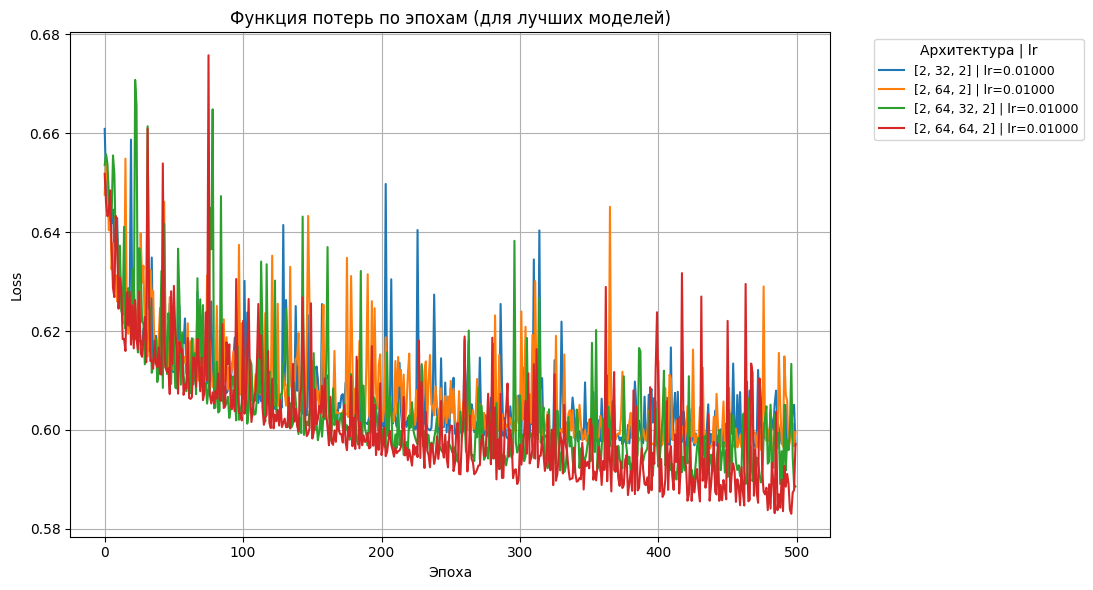

In [ ]:
best_by_arch = {}

for key, val in results.items():
    arch = str(val['architecture']) 
    current_loss = val['loss']
    current_lr = val['learning_rate']
    
    if arch not in best_by_arch or current_loss < best_by_arch[arch]['loss']:
        best_by_arch[arch] = val
        
plt.figure(figsize=(14, 6))
for arch_str, res in best_by_arch.items():
    plt.plot(res['losses'], label=f"{arch_str} | lr={res['learning_rate']:.5f}")

plt.title("Функция потерь по эпохам (для лучших моделей)")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend(title="Архитектура | lr", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.8, 1]) 
plt.show()

### Обучение и предсказание

In [15]:
best_model_name = min(results, key=lambda k: results[k]['loss'])

best_architecture = results[best_model_name]['architecture']
best_learning_rate = results[best_model_name]['learning_rate']
print(f"Best architecture: {best_architecture}, learning rate: {best_learning_rate}") 

model = NeuralNetwork(best_architecture, 
                      activation='relu',
                      task='classification')
loses = model.train(X_train_scaled, y_train, 
                    epochs=500, 
                    batch_size=32, 
                    learning_rate=best_learning_rate)

y_pred = model.predict(X_test_scaled)

Best architecture: [2, 64, 32, 2], learning rate: 0.01
Epoch 100/500, Loss: 0.6132, Accuracy: 68.86%
Epoch 200/500, Loss: 0.6032, Accuracy: 69.66%
Epoch 300/500, Loss: 0.6013, Accuracy: 69.66%
Epoch 400/500, Loss: 0.5950, Accuracy: 70.14%
Epoch 500/500, Loss: 0.5915, Accuracy: 70.79%


### Визуализация

Test accuracy: 68.28%


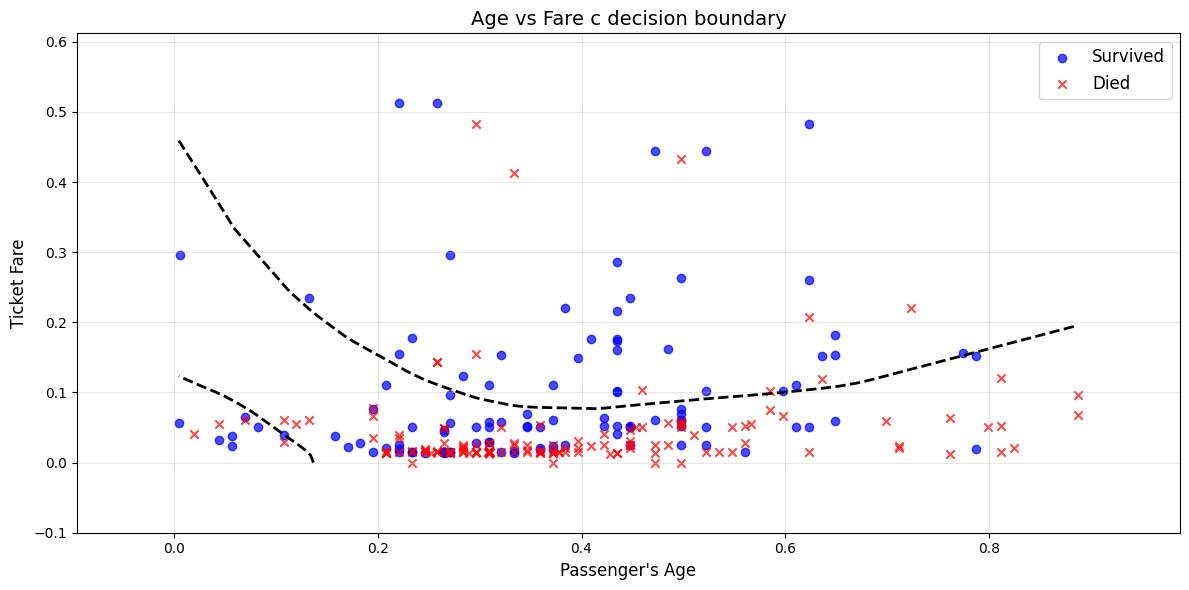

In [16]:
test_accuracy = accuracy(y_test, y_pred)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(12, 6))

y_pred_probs = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

age = X_test_scaled[:, 0]
fare = X_test_scaled[:, 1]

y_test_flat = y_test.argmax(axis=1) if len(y_test.shape) > 1 else y_test.flatten()

survived_age = age[y_test_flat == 1]
survived_fare = fare[y_test_flat == 1]
died_age = age[y_test_flat == 0]
died_fare = fare[y_test_flat == 0]

plt.scatter(survived_age, survived_fare, color='blue', label='Survived', alpha=0.7, marker='o')
plt.scatter(died_age, died_fare, color='red', label='Died', alpha=0.7, marker='x')

L = len(model.parameters) // 2

x1_vals = np.linspace(age.min(), age.max(), 100)
x2_vals = np.linspace(fare.min(), fare.max(), 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

grid_points = np.c_[X1.ravel(), X2.ravel()]

Z_probs, _ = model.forward(grid_points)

if Z_probs.shape[1] == 2:
    Z_class = Z_probs[:, 1].reshape(X1.shape)
else:
    Z_class = Z_probs.reshape(X1.shape)

plt.contour(X1, X2, Z_class, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)

plt.title('Age vs Fare с decision boundary', fontsize=14)
plt.xlabel("Passenger's Age", fontsize=12)
plt.ylabel("Ticket Fare", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(age.min() - 0.1, age.max() + 0.1)
plt.ylim(fare.min() - 0.1, fare.max() + 0.1)
plt.tight_layout()
plt.show()